# Project - Deep Generative Models

In this project we will explore three main things:
1. The relationship between linear autoencoders and PCA.
2. Training Generative Adversarial Networks.
3. Using already-trained GANs.


**Remember to activate GPUs in Colab**.

## Implementing Autoencoders

In these exercises we will implement autoencoders in PyTorch.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

mnist = MNIST('../data', train=True, download=True)

C:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Exercise 1

Below you will find a boilerplate code for a Linear Autoencoder. We will use it on MNIST data, and compare with the result of reducing the dimensionality using PCA.

1. Fill the `self.encoder` and `self.decoder` to be linear layers from `28*28` to `2` and from `2` to `28*28` respectively. Implement the decoder to have a `sigmoid` activation function.
2. Define a `forward` function that represents the forward pass of the network: encode the input `x`, and then decode it to get `x_tilde`.
3. Why did we go for a `sigmoid` activation in the decoder?

In [2]:
class LinearAutoEncoder(nn.Module):
    def __init__(self):
        super(LinearAutoEncoder, self).__init__()
        self.encoder = nn.Linear(28*28, 2)
        self.decoder = nn.Sequential(
            nn.Linear(2, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_tilde = self.decoder(self.encoder(x))
        return x_tilde

In [3]:
lae = LinearAutoEncoder()
print(lae)

LinearAutoEncoder(
  (encoder): Linear(in_features=784, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


### Exercise 2

Let's preprocess the `mnist.data`.
1. Call it `x`.
2. Normalize by dividing `x` by `255.0`.
3. How many digits are in `x`?
4. Reshape x to be `(x.shape[0], 28*28)`

In [4]:
x = mnist.data
x = torch.div(x, 255.0)
print(torch.min(x))
print(torch.max(x))
x.size()

tensor(0.)
tensor(1.)


torch.Size([60000, 28, 28])

In [5]:
x = torch.reshape(x, (-1, 784))
x.size()

torch.Size([60000, 784])

### Exercise 3

Plot the first 3 digits using `plt.subplots`. Remember to use `.detach().numpy()` if you want to plot images using `matplotlib`.

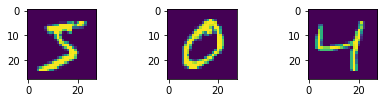

In [6]:
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.imshow(x[i].reshape(28,28), interpolation='none')
    plt.tight_layout()

### Exercise 4

Let's define the loss function for the training. In this case, use the **sum-of-squares reconstruction error**. Assume the inputs `x` and `x_prime` are flat vectors. (Hint. Check `MSELoss`)

In [7]:
def loss_function(x, x_prime) -> torch.Tensor:
    loss =  nn.MSELoss()
    return loss(x, x_prime)

### Exercise 5

Now we train:
1. Define your favorite optimizer, with your favorite learning rate.
2. Below you will find a boilerplate function for the `train` function. Fill in the blanks. We will overfit the model, since the goal here is to practice with AEs, not to get perfect reconstructions.
3. Run the `train` function on the `lae` model with the `data_loader` we defined, and 50 epochs.

In [8]:
# Defining the things we will need.
dataset = TensorDataset(x)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lae = LinearAutoEncoder().to(device)

In [9]:
lr = 0.01
optimizer = torch.optim.Adam(lae.parameters(), lr)

In [10]:
def train(model: LinearAutoEncoder, data_loader: DataLoader, optimizer: torch.optim.Optimizer, epochs: int):
    model.train()
    for epoch in range(epochs):
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch}", end=" ")

        running_epoch_loss = 0.0
        for batch in data_loader:
            x_batch = batch[0].to(device)

            # Reset the gradients to zero in the optimizer
            optimizer.zero_grad()

            # Do a forward pass of this batch on the model
            x_prime = model.forward(x_batch)

            # Compute the loss
            loss = loss_function(x_batch, x_prime)
            running_epoch_loss += loss.item()

            # Propagate the loss backwards
            loss.backward()

            # Do a step in the optimizer
            optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:    
            print(f"loss: {running_epoch_loss / len(dataset)}")

In [11]:
train(lae, data_loader, optimizer, 50)

Epoch: 0 loss: 0.0010609700690954924
Epoch: 10 loss: 0.0008670925823971629
Epoch: 20 loss: 0.0008660067591195305
Epoch: 30 loss: 0.000865824094042182
Epoch: 40 loss: 0.0008656366803993781
Epoch: 49 loss: 0.0008657054073487719


### Exercise 6

Let's print a number and it's reconstruction according to the AE:
1. Make a 2-figure subplot.
2. In one axis, plot the first digit `x[0].view(28, 28)`
3. In another, plot the reconstruction `lae(x[0]).view(28, 28)`.

**Warning**. You might need to use `.to(device)` when running on GPU, and `.cpu()` for plotting.

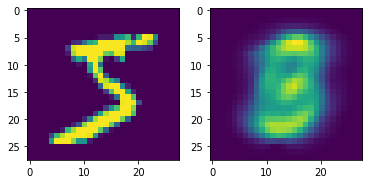

In [12]:
plt.subplot(1,2,1)
plt.imshow(x[0].view(28,28), interpolation='none')
plt.subplot(1,2,2)
lae_cpu = lae.cpu()
plt.imshow(lae_cpu(x[0]).detach().numpy().reshape(28,28), interpolation='none')


## A better Autoencoder

As you might have seen, the reconstructions of a linear autoencoder on MNIST are not great. In these three exercises we use the code we have already implemented to train a deeper non-linear autoencoder.

### Exercise 7

In the following you will find an implementation for an autoencoder with one hidden layer in each the encoder and decoder. Fill in the blanks. We leave it up to you to select the number for the amount of nodes in the hidden layers. Remember to add a sigmoid activation to the decoder (why?).

R: 

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        n_hidden = 128
        self.encoder = nn.Sequential(
          nn.Linear(784, n_hidden),
          nn.Linear(n_hidden, n_hidden),
          nn.Linear(n_hidden, 2)
        ) 

        self.decoder = nn.Sequential(
          nn.Linear(2, n_hidden),
          nn.Linear(n_hidden, n_hidden),
          nn.Linear(n_hidden, 784),
          nn.Sigmoid()
        ) 

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)
  
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)
  
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_tilde = self.decoder(self.encoder(x))
        return x_tilde

In [14]:
ae = AutoEncoder().to(device)
print(ae)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


### Exercise 8

1. Create an optimizer of the parameters of your autoencoder `ae`.
2. Use the `train` function we defined above to train your autoencoder `ae`. Train for 50 epochs.

In [15]:
ae_lr = 0.001
ae_optimizer = torch.optim.Adam(ae.parameters(), ae_lr)

In [16]:
train(ae, data_loader, ae_optimizer, 50)

Epoch: 0 loss: 0.0009146983506778876
Epoch: 10 loss: 0.0008629569317524632
Epoch: 20 loss: 0.0008623350116113822
Epoch: 30 loss: 0.0008621534084901213
Epoch: 40 loss: 0.0008620422191917896
Epoch: 49 loss: 0.0008618840578943491


### Exercise 9

Print the reconstruction of the first digit in a similar way as in exercise 6.

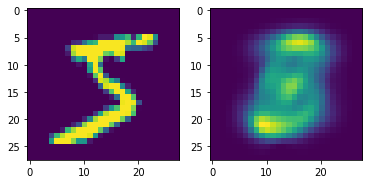

In [17]:
plt.subplot(1,2,1)
plt.imshow(x[0].view(28,28), interpolation='none')
plt.subplot(1,2,2)
ae_cpu = ae.cpu()
plt.imshow(ae_cpu(x[0]).detach().numpy().reshape(28,28), interpolation='none')


Slightly better, but still not great.

## Implementing a Generative Adversarial Network

In the following examples we will implement a Generative Adversarial Network to sample from the MNIST distribution.

### Exercise 10

1. If we want the discriminator to "classify" between real and fake, what would be an appropiate activation function?
R: We would want a function bound to (0, 1). We could either take a binary step function, if we do not care abut uncertainty, or even better a sigmoid function.
2. In what follows we will create the two antagonist networks that compete in the minimax game we described in the slides. Fill in the blanks and keep into account the answer to 10.1.

In [18]:
class GAN_Discriminator(nn.Module):
    def __init__(self):
        super(GAN_Discriminator, self).__init__()

        n_hidden = 128
        self.input_layer = nn.Sequential(
            nn.Linear(28*28, n_hidden),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(n_hidden, 1),
            nn.Sigmoid()
        )
  
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.output_layer(self.input_layer(x))

In [19]:
D = GAN_Discriminator()
D

GAN_Discriminator(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [20]:
class GAN_Generator(nn.Module):
    def __init__(self):
        super(GAN_Generator, self).__init__()

        n_hidden = 128
        self.input_layer = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(n_hidden, 28*28),
            nn.Sigmoid()
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.output_layer(self.input_layer(z))

In [21]:
G = GAN_Generator()
G

GAN_Generator(
  (input_layer): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

### Exercise 11

In what follows we will implement a `train_GAN` function that takes the two models `D` and `G` we defined above. Fill in the blanks.

In [32]:
classification_loss = torch.nn.BCELoss()

def train_GAN(
    D: GAN_Discriminator,
    G: GAN_Generator,
    opt_D: torch.optim.Optimizer,
    opt_G: torch.optim.Optimizer,
    data_loader: DataLoader,
    epochs: int
  ):
  for epoch in range(epochs):
    running_loss_D, running_loss_G = 0.0, 0.0
    for real_batch, in data_loader:
      real_batch = real_batch.to(device)
      
      # Getting random zs
      batch_size, _ = real_batch.shape

      ##! Create a random vector of shape (batch_size, 2), finish with .to(device) 
      random_z = torch.randn((batch_size, 2)).to(device)

      # Minimizing w.r.t. D
      D.train()
      opt_D.zero_grad()

      ## Computing the Discriminator at both
      D_at_x = D(real_batch)
      G_at_z = G(random_z)

      ### Correctly classifying the real ones
      loss_D_reals = classification_loss(
          D_at_x,
          torch.ones(batch_size, 1).to(device)
      )

      ### Correctly classifying the fake ones
      loss_D_fakes = classification_loss(
          D(G_at_z.detach()),
          torch.zeros(batch_size, 1).to(device)
      )

      ##! Take the average of loss_D_reals and loss_D_fakes
      loss_D = (loss_D_reals + loss_D_fakes) / 2

      ##! Optimizer step. Fill in the blanks.
      running_loss_D += loss_D.item()
      loss_D.backward()
      opt_D.step()

      D.eval()

      # Maximizing w.r.t G
      G.train()
      opt_G.zero_grad()

      ## Computing fakes with G.
      G_at_z = G(random_z)

      ## Computing the missclassification of the Discriminator
      loss_G = classification_loss(
          D(G_at_z),
          torch.ones(batch_size, 1).to(device)
      )
      
      ##! Optimizer step. Fill in the blanks
      running_loss_G += loss_G.item()
      loss_G.backward()
      opt_G.step()

      G.eval()

    # Printing utilities. Don't worry about this.
    if epoch % 10 == 0 or epoch == epochs - 1:
      print(f"Epoch {epoch}, loss D: {running_loss_D/len(data_loader):.5f}, loss G: {running_loss_G/len(data_loader):.5f}")
      print("Random samples:")
      _, axes = plt.subplots(1, 3)
      for fake_img, ax in zip(G_at_z, axes):
        ax.axis("off")
        img = fake_img.view(28, 28).cpu().detach().numpy()
        ax.imshow(img, vmin=0, vmax=1)

      plt.show()
      plt.close()

We will train this GAN for 100 epochs.
1. Start by defining instances of our generator and discriminator (remember to use `.to(device)`)
2. Define two optimizers (one for each network), and set a learning rate less than or equal to `0.001`.
3. Run the `train_GAN` function with 100 epochs.

Epoch 0, loss D: 0.08518, loss G: 4.85065
Random samples:


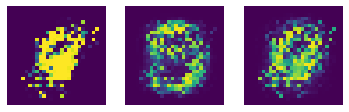

Epoch 10, loss D: 0.03992, loss G: 5.92612
Random samples:


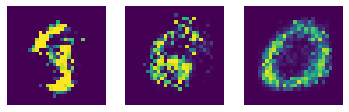

Epoch 20, loss D: 0.02666, loss G: 7.75824
Random samples:


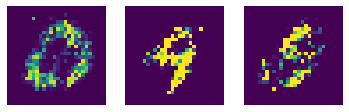

Epoch 30, loss D: 0.02300, loss G: 9.09256
Random samples:


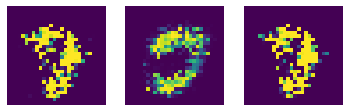

Epoch 40, loss D: 0.02557, loss G: 9.52596
Random samples:


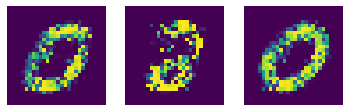

Epoch 50, loss D: 0.04070, loss G: 10.90017
Random samples:


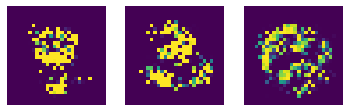

Epoch 60, loss D: 0.02483, loss G: 10.54326
Random samples:


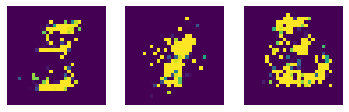

Epoch 70, loss D: 0.03262, loss G: 8.78599
Random samples:


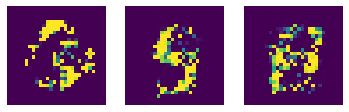

Epoch 80, loss D: 0.03008, loss G: 8.76620
Random samples:


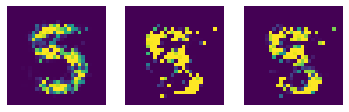

Epoch 90, loss D: 0.02347, loss G: 10.01792
Random samples:


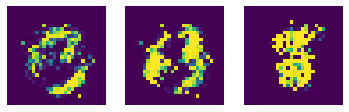

Epoch 99, loss D: 0.03874, loss G: 8.94965
Random samples:


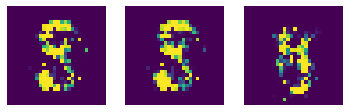

In [33]:
D = GAN_Discriminator().to(device)
G = GAN_Generator().to(device)

opt_G = torch.optim.Adam(G.parameters(), 0.001)
opt_D = torch.optim.Adam(D.parameters(), 0.001)

train_GAN(D, G, opt_D, opt_G, data_loader, 100)

### Exercise 12

1. Get a random vector `z` of shape `(1000, 2)` using `torch.randn`.
2. Get the generated images for said `z` using our generator `G`.
3. Plot them in the latent space using the auxiliary function we provide.

In [34]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_images(z: torch.Tensor, fakes: torch.Tensor):
  """
  Plots the fake images in {fakes} at positions {z}.
  """
  _, ax = plt.subplots(1, 1)

  z = z.cpu().detach().numpy()
  images = fakes.view(fakes.shape[0], 28, 28)
  images = images.cpu().detach().numpy()

  for zi, img in zip(z, images):
    im = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(im, zi, xycoords='data', frameon=False)
    ax.add_artist(ab)
    ax.update_datalim([zi])
    ax.autoscale()

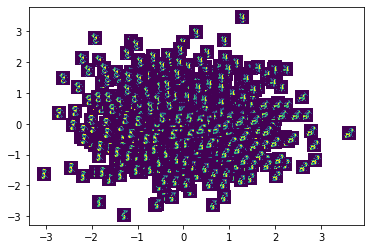

In [38]:
z = torch.randn((1000,2)).to(device)
fakes = G(z)
plot_images(z, fakes)